In [5]:
import pydub 
import numpy as np
import sys
sys.path.insert(0, 'tools/bandcamp-scrapper-neo4j')
import db_transcations as dbt

In [ ]:
def readmp3(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    segments = y
    if a.channels == 2:
        y = y.reshape((-1, 2))
        samplesxchunk = a.frame_rate*10
        nchunks = int(np.floor(len(y)/(samplesxchunk)))
        
        segments = [y[samplesxchunk*i:samplesxchunk*(i+1)] for i in range(nchunks)]
    if normalized:
        return a.frame_rate, segments.apply(np.float32(it) / 2**15)
    else:
        return a.frame_rate, segments

In [ ]:
def writemp3(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

In [107]:
album_scrape = dbt.getAlbumwithParams(["chicago"], fans=[], skip=[2])
album_scrape = album_scrape[:3]
album_urls = [a.url for a in album_scrape]

In [108]:
print(album_scrape)

[<Album: {'uid': '7908f6d786184d59b9778a38039bac39', 'url': 'https://undercomm.bandcamp.com/album/great-white-arc', 'name': 'Great White Arc', 'band_name': 'Young Light', 'id': 16073}>, <Album: {'uid': 'cfb918fc7db24d94b017ddb6cfa5fc7c', 'url': 'https://proswell.dsp.coffee/album/declination-diagrams-map-legend-reworks', 'name': 'Declination Diagrams (Map Legend Reworks)', 'band_name': 'Cayos + Proswell', 'id': 459261}>, <Album: {'uid': 'c5ee871ff9de461f8412223fad249e9b', 'url': 'https://octopusinc.bandcamp.com/album/symmetrical-dogz', 'name': 'Symmetrical Dogz', 'band_name': 'getdizzzy', 'id': 459164}>]


In [109]:
import os
import subprocess
def download_song(url):
    bash_cmd = "bandcamp-dl -n -y --template='%{album}/%{track}' --base-dir ./dl/ " + url
    os.system(bash_cmd)

In [110]:
for i,album in enumerate(album_scrape):
    download_song(album.url)
    os.system(f"mv \"dl/{album.name}\" \"dl/{album.uid}\"")
    try:
        tracks = subprocess.check_output(['ls','-1',f"dl/{album.uid}"])
        album_scrape[i].ntracks = len(tracks.split())
    except subprocess.CalledProcessError as err:
        print(err)
print(album_scrape)

(4/4) [==================================================] :: Finished: 04     
(4/4) [==================================================] :: Finished: 04     
(6/6) [==================================================] :: Finished: 06     
[<Album: {'uid': '7908f6d786184d59b9778a38039bac39', 'url': 'https://undercomm.bandcamp.com/album/great-white-arc', 'name': 'Great White Arc', 'band_name': 'Young Light', 'id': 16073, 'ntracks': 4}>, <Album: {'uid': 'cfb918fc7db24d94b017ddb6cfa5fc7c', 'url': 'https://proswell.dsp.coffee/album/declination-diagrams-map-legend-reworks', 'name': 'Declination Diagrams (Map Legend Reworks)', 'band_name': 'Cayos + Proswell', 'id': 459261, 'ntracks': 4}>, <Album: {'uid': 'c5ee871ff9de461f8412223fad249e9b', 'url': 'https://octopusinc.bandcamp.com/album/symmetrical-dogz', 'name': 'Symmetrical Dogz', 'band_name': 'getdizzzy', 'id': 459164, 'ntracks': 6}>]


In [115]:
∑

['/Users/tonihurtado/dev/bandcamp-experiment/dl/c5ee871ff9de461f8412223fad249e9b/01.mp3',
 '/Users/tonihurtado/dev/bandcamp-experiment/dl/c5ee871ff9de461f8412223fad249e9b/02.mp3',
 '/Users/tonihurtado/dev/bandcamp-experiment/dl/c5ee871ff9de461f8412223fad249e9b/03.mp3',
 '/Users/tonihurtado/dev/bandcamp-experiment/dl/c5ee871ff9de461f8412223fad249e9b/04.mp3',
 '/Users/tonihurtado/dev/bandcamp-experiment/dl/c5ee871ff9de461f8412223fad249e9b/05.mp3',
 '/Users/tonihurtado/dev/bandcamp-experiment/dl/c5ee871ff9de461f8412223fad249e9b/06.mp3']

dl/7908f6d786184d59b9778a38039bac39/01.mp3
dl/7908f6d786184d59b9778a38039bac39/02.mp3
dl/7908f6d786184d59b9778a38039bac39/03.mp3
dl/cfb918fc7db24d94b017ddb6cfa5fc7c/01.mp3
dl/cfb918fc7db24d94b017ddb6cfa5fc7c/02.mp3
dl/cfb918fc7db24d94b017ddb6cfa5fc7c/03.mp3
dl/c5ee871ff9de461f8412223fad249e9b/01.mp3
dl/c5ee871ff9de461f8412223fad249e9b/02.mp3
dl/c5ee871ff9de461f8412223fad249e9b/03.mp3
dl/c5ee871ff9de461f8412223fad249e9b/04.mp3
dl/c5ee871ff9de461f8412223fad249e9b/05.mp3


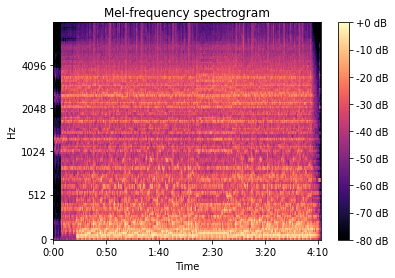

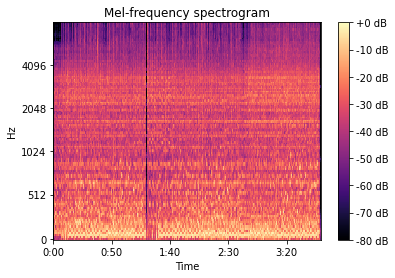

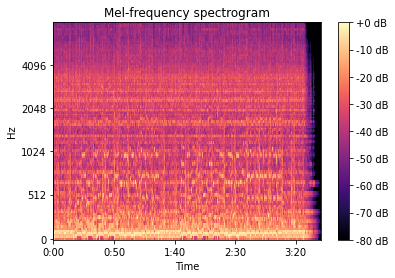

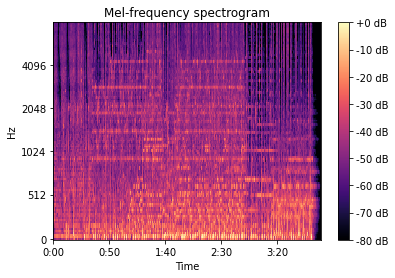

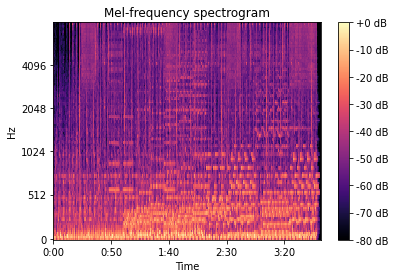

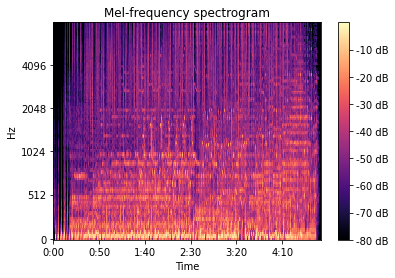

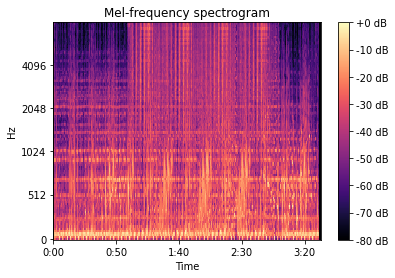

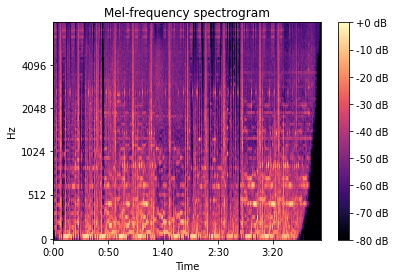

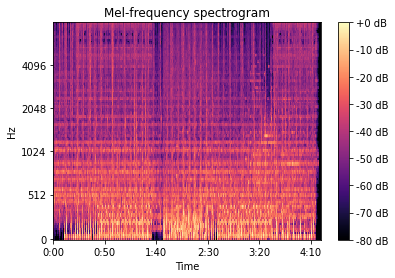

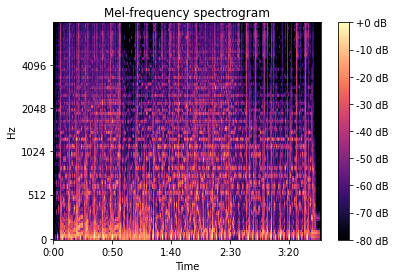

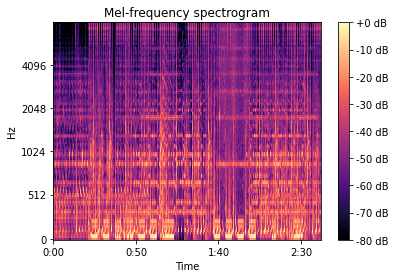

In [112]:
pitches = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

for i,album in enumerate(album_scrape):
    ipath = f"dl/{album.uid}"
    album_scrape[i].tracks = {}
    for tr in range(1,album.ntracks + 1): #librosa.util.find_files(ipath)
        tr_id = f"{ipath}/{tr:02}"
        AUDIO_FILE = f"{tr_id}.mp3"
        print(AUDIO_FILE)
        y, sr = librosa.load(AUDIO_FILE)
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
        track_tempo = int(tempo)

        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
        fig, ax = plt.subplots()
        S_dB = librosa.power_to_db(S, ref=np.max)
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr,fmax=8000, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title='Mel-frequency spectrogram')
        fig.savefig(AUDIO_FILE.replace('.mp3','.png'))
        mel_file = AUDIO_FILE.replace('.mp3','.png')
        
        chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
        song_chroma = [np.mean(a) for a in chroma]
        # select the most dominate pitch
        pitch_id = song_chroma.index(max(song_chroma))
        pitch = pitches[pitch_id]

        min_third_id = (pitch_id+3)%12
        maj_third_id = (pitch_id+4)%12

        #check if the musical 3rd is major or minor
        if song_chroma[min_third_id] < song_chroma[maj_third_id]:
            third = 'major'
        elif song_chroma[min_third_id] > song_chroma[maj_third_id]:
            third = 'minor'
        track_key = f"{pitch}{third}"

        track_data = {
            "audio_file": AUDIO_FILE,
            "mel_file": mel_file,
            "tempo": track_tempo,
            "key": track_key

        }
        album_scrape[i].tracks[tr_id] = track_data



In [114]:
from pprint import pprint
pprint(album_scrape)

[<Album: {'uid': '7908f6d786184d59b9778a38039bac39', 'url': 'https://undercomm.bandcamp.com/album/great-white-arc', 'name': 'Great White Arc', 'band_name': 'Young Light', 'id': 16073, 'ntracks': 4, 'tracks': {'dl/7908f6d786184d59b9778a38039bac39/01': {'audio_file': 'dl/7908f6d786184d59b9778a38039bac39/01.mp3', 'mel_file': 'dl/7908f6d786184d59b9778a38039bac39/01.png', 'tempo': 135, 'key': 'C#major'}, 'dl/7908f6d786184d59b9778a38039bac39/02': {'audio_file': 'dl/7908f6d786184d59b9778a38039bac39/02.mp3', 'mel_file': 'dl/7908f6d786184d59b9778a38039bac39/02.png', 'tempo': 123, 'key': 'Bminor'}, 'dl/7908f6d786184d59b9778a38039bac39/03': {'audio_file': 'dl/7908f6d786184d59b9778a38039bac39/03.mp3', 'mel_file': 'dl/7908f6d786184d59b9778a38039bac39/03.png', 'tempo': 135, 'key': 'Gmajor'}}}>,
 <Album: {'uid': 'cfb918fc7db24d94b017ddb6cfa5fc7c', 'url': 'https://proswell.dsp.coffee/album/declination-diagrams-map-legend-reworks', 'name': 'Declination Diagrams (Map Legend Reworks)', 'band_name': 'Cayo

In [69]:
import librosa
# Load the audio file
AUDIO_FILE = 'dl/03 Acid Open.mp3'

y, sr = librosa.load(AUDIO_FILE,duration=120) #readmp3(AUDIO_FILE)

In [70]:
from IPython.display import Audio
y_harmonic, y_percussive = librosa.effects.hpss(y)
Audio(data=y, rate=sr)
Audio(data=y_harmonic, rate=sr)
Audio(data=y_percussive, rate=sr)

In [71]:
onset_env = librosa.onset.onset_strength(y=y_percussive, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
print(tempo)

[123.046875]


[Text(0.5, 1.0, 'Tempogram')]

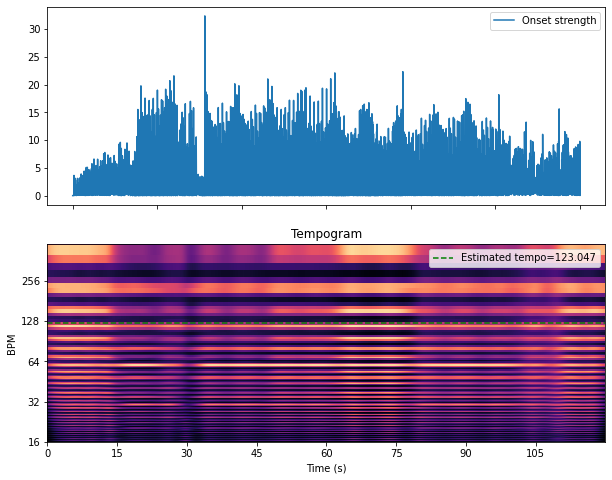

In [72]:
tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr)
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(onset_env, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))
times = librosa.times_like(onset_env, sr=sr)
ax[0].plot(times, onset_env, label='Onset strength')
ax[0].label_outer()
ax[0].legend(frameon=True)
librosa.display.specshow(tempogram, sr=sr,x_axis='s', 
     y_axis='tempo', cmap='magma',ax=ax[1])
ax[1].axhline(tempo, color='g', linestyle='--', alpha=1,
            label='Estimated tempo={:g}'.format(tempo))
ax[1].legend(loc='upper right')
ax[1].set(title='Tempogram')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

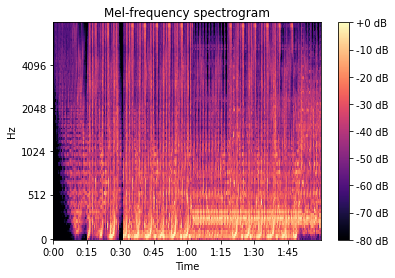

In [73]:
import matplotlib.pyplot as plt
import librosa.display

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

/var/folders/lz/x_5xnmyj33g_kscqc02gckpw0000gn/T/ipykernel_42498/2580314242.py:1: FutureWarning: Pass y=[ 2.4277408e-06  1.2072340e-06 -5.8932656e-06 ...  6.4250335e-02
  6.4052634e-02  6.7197986e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(y, sr=sr)


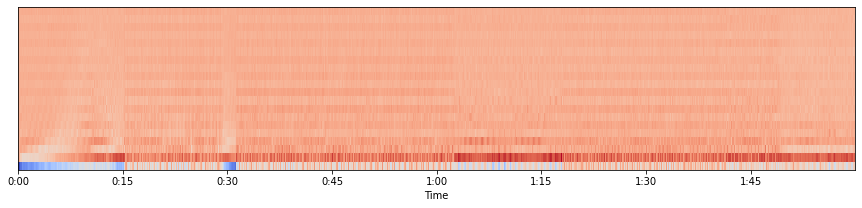

In [74]:
mfccs = librosa.feature.mfcc(y, sr=sr)
# Displaying  the MFCCs:
plt.figure(figsize=(15, 3))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

/var/folders/lz/x_5xnmyj33g_kscqc02gckpw0000gn/T/ipykernel_42498/3172082410.py:2: FutureWarning: Pass y=[-6.6440380e-06 -2.9058543e-05  5.8657793e-06 ...  9.0522006e-02
  9.2204735e-02  9.0228640e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  chromagram = librosa.feature.chroma_stft(y_harmonic, sr=sr, hop_length=hop_length)


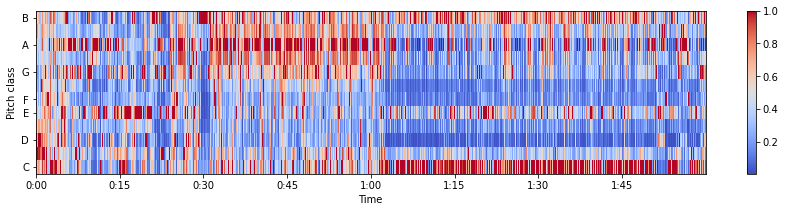

In [76]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(y_harmonic, sr=sr, hop_length=hop_length)
fig, ax = plt.subplots(figsize=(15, 3))
img = librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
fig.colorbar(img, ax=ax)

In [77]:
chroma = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
song_chroma = [np.mean(a) for a in chroma]

In [79]:
# pitches in 12 tone equal temperament 
pitches = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
# print note to value relations
for key in range(len(song_chroma)):
    print(str(pitches[key]) + '\t' + str(song_chroma[key]))

# select the most dominate pitch
pitch_id = song_chroma.index(max(song_chroma))
pitch = pitches[pitch_id]

min_third_id = (pitch_id+3)%12
maj_third_id = (pitch_id+4)%12

#check if the musical 3rd is major or minor
if song_chroma[min_third_id] < song_chroma[maj_third_id]:
    third = 'major'
    print(str.format('\nThis song is likely in {} {}',pitch, third))
elif song_chroma[min_third_id] > song_chroma[maj_third_id]:
    third = 'minor'
    print(str.format('\nThis song is likely in {} {}',pitch, third))

C	0.54034084
C#	0.29945588
D	0.268363
D#	0.20664531
E	0.4404912
F	0.24930717
F#	0.2659752
G	0.53775156
G#	0.6070209
A	0.8680102
A#	0.56415796
B	0.5687209

This song is likely in A minor


In [ ]:
#write samples to audio
for sample in samples:
    writemp3('tests/sample-' + str(sample[0]) + '.mp3',sample_rate,sample)

In [ ]:
#plot each segment
import matplotlib.pyplot as plt
for sample in samples:
    plt.figure(1)
    plt.title("Signal Wave...")
    plt.plot(sample)
    plt.show()